In [1]:
import gensim
import math
import nltk
import numpy as np
import operator
import pandas as pd
import pickle
import pydotplus
import random
import re
import seaborn as sns
import string
import sys
import time
import warnings
import zipfile

from collections import Counter

from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.models.lsimodel import LsiModel

from gensim.utils import simple_preprocess
from gensim.utils import simple_preprocess

from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

from io import StringIO

from IPython.display import Image

from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
from matplotlib import ticker

from mlxtend.classifier import StackingClassifier

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.stem.wordnet import WordNetLemmatizer

from pprint import pprint

import pyLDAvis
import pyLDAvis.gensim

from scipy import stats
from scipy.cluster import hierarchy as sch

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_moons
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectPercentile
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_fscore_support as error_metric
from sklearn.metrics import r2_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

from string import punctuation

from textblob import TextBlob

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from wordcloud import WordCloud
from wordcloud import STOPWORDS

from xgboost import XGBClassifier
from xgboost import XGBRegressor

warnings.filterwarnings("ignore")
np.set_printoptions(threshold=sys.maxsize)

There were 840 staterooms in all, 416 in First Class, 162 in Second Class, and 262 in Third Class.
Titanic's passengers numbered 1,317 people: 324 in first class, 284 in second class, and 709 in third class

49% – the percentage of passenger places that went unused (the loss of life could have been far great still).

#### Total Capacity
* Capacity: 3,547
* Existed: 2,222

#### Total Staff Capacity
* Capacity: 945
* Existed: 885

#### Total Passenger Capacity
* Capacity: 2566 
* Existed: 1317

#### First Class
* Capacity: 1034
* Existed: 325

#### Second Class
* Capacity: 510
* Existed: 285

#### Third Class
* Capacity: 1022
* Existed: 706

#### Life belts
* 3560 <br><br>

* <code>Single men</code> were housed in the <code>bow</code> while <code>single women</code> and <code>families</code> were accommodated in the stern section, with families occupying the larger cabins.
* ...all of whom were housed in private cabins of no more than 10 people
* 84 two-berth cabins for the Third-class, and in all, 1,100 Third-class passengers could be accommodated

In [2]:
def check_null(df, **kwargs):
    '''Returns a dataframe which contains the number, % and bool of
    missing values in columns'''
    to_return = df.isnull().sum().to_frame()
    to_return.columns = ['Number_Missing']
    to_return['% Missing'] = (to_return['Number_Missing']/len(df))*100
    to_return['Missing?'] = df.isnull().any()
    
    print(f'Total Columns: {len(df)}')
    
    if 'omit' in kwargs:
        if kwargs['omit'] == False:
            return to_return.sort_values(by='Number_Missing', ascending=False)
    
    to_return = to_return[ to_return['Number_Missing'] > 0 ]
    
    if len(to_return) == 0:
        print('No missing values found.')
        return
    
    return to_return.sort_values(by='Number_Missing', ascending=False)

def attach_frequency(df, column):
    '''Takes a dataframe and column name as input. Returns the dataframe
    with an additional column which contains the freqeuncy of the values
    in the column'''
    frequency = df[column].value_counts().to_frame().reset_index()
    frequency.columns = [column, f'{column}_frequency']
    return pd.merge(left=df, right=frequency, on=column, how='left')

def check_recurring(df):
    
    check_df = pd.DataFrame()
    check_df['Column'] = df.columns
    
    unique = []
    for column in check_df['Column']:
        unique.append(df[column].nunique())
    check_df['Unique Values'] = unique
    
    not_null = []
    for column in check_df['Column']:
        not_null.append(len(df[df[column].notnull()]))
    check_df['Not Null Values'] = not_null
    
    check_df['Ratio to Total Number'] = check_df['Unique Values'] / check_df['Not Null Values']
    
    has_null = []
    for column in check_df['Column']:
        has_null.append(True if len(df[df[column].isnull()]) >= 1 else False)
    check_df['Has Null'] = has_null
    
    check_df.sort_values(by=['Has Null', 'Ratio to Total Number'], ascending=(False, True), inplace=True)
    
    return check_df

def set_x_tick_labels(multiples=10):
    '''A code snippet used for formatting the X axis
    ticker value occurences'''
    ax = plt.gca()
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(base=multiples))
    plt.show()

In [3]:
path_train = "data/train.csv"
path_test = "data/test.csv"
path_submission = "data/gender_submission.csv"

In [4]:
df_train = pd.read_csv(path_train)
df_test = pd.read_csv(path_test)
df_submission = pd.read_csv(path_submission)

In [5]:
data = pd.concat([df_train, df_test])

In [6]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
data = data[[ i for i in data.columns if i != 'Survived'] + ['Survived']]
data.set_index(keys=['PassengerId'], inplace=True)
data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
PassengerId,,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0.0
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1.0
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1.0
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1.0
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0.0


## 1 Data Cleaning and Feature Engineering

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    1309 non-null   int64  
 1   Name      1309 non-null   object 
 2   Sex       1309 non-null   object 
 3   Age       1046 non-null   float64
 4   SibSp     1309 non-null   int64  
 5   Parch     1309 non-null   int64  
 6   Ticket    1309 non-null   object 
 7   Fare      1308 non-null   float64
 8   Cabin     295 non-null    object 
 9   Embarked  1307 non-null   object 
 10  Survived  891 non-null    float64
dtypes: float64(3), int64(3), object(5)
memory usage: 122.7+ KB


In [9]:
column_type = ['Ordinal', 'Nominal', 'Nominal', 'Continuous', 
               'Discrete', 'Discrete', 'Nominal', 'Continuous',
               'Nominal', 'Nominal', 'Ordinal']
column_type = {key: value for key, value in zip(data.columns, column_type)}
column_type

{'Pclass': 'Ordinal',
 'Name': 'Nominal',
 'Sex': 'Nominal',
 'Age': 'Continuous',
 'SibSp': 'Discrete',
 'Parch': 'Discrete',
 'Ticket': 'Nominal',
 'Fare': 'Continuous',
 'Cabin': 'Nominal',
 'Embarked': 'Nominal',
 'Survived': 'Ordinal'}

In [10]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Pclass,1309.0,2.294882,0.837836,1.00,2.0000,3.0000,3.000,3.0000
Age,1046.0,29.881138,14.413493,0.17,21.0000,28.0000,39.000,80.0000
SibSp,1309.0,0.498854,1.041658,0.00,0.0000,0.0000,1.000,8.0000
Parch,1309.0,0.385027,0.865560,0.00,0.0000,0.0000,0.000,9.0000
Fare,1308.0,33.295479,51.758668,0.00,7.8958,14.4542,31.275,512.3292
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.000,1.0000


* Age contains float values as well, which would be better if kept as discrete int values.
* Looks like values in Fare are spread out and may contain outliers.

In [11]:
data['Age'].update( data[ data['Age'].notnull() ]['Age'].apply(
                        lambda x: int(round(float(x))) 
                                    if type(x) == float 
                                    else np.nan))

In [12]:
data['Fare'].value_counts()

8.0500     60
13.0000    59
7.7500     55
26.0000    50
7.8958     49
           ..
33.5000     1
7.8000      1
26.3875     1
15.5792     1
7.1417      1
Name: Fare, Length: 281, dtype: int64

* Fare shouldn't have more than 2 decimal places. Rounding it off to 2 decimal places.

In [13]:
data['Fare'] = data['Fare'].apply(lambda x: round(x, ndigits=2))

* It may be possible that some people shared tickets. Checking validity of assumption.

In [14]:
grouped_tickets = data.groupby('Ticket').groups

ticket_shared_with = {}

for ticket in grouped_tickets:
    ticket_shared_with[ticket] = len(grouped_tickets[ticket])

data['Ticket Shared With'] = 0
for ticket in ticket_shared_with:
    data['Ticket Shared With'] = np.where( data['Ticket'] == ticket, 
                                          ticket_shared_with[ticket], 
                                          data['Ticket Shared With'])

In [15]:
data['Ticket Shared With'].sort_values(ascending=False)

PassengerId
181     11
325     11
864     11
847     11
1257    11
        ..
741      1
740      1
739      1
735      1
1        1
Name: Ticket Shared With, Length: 1309, dtype: int64

* Assumption verified to be true. Upto 11 people shared the same ticket.
* Now because the tickets were shared, it should be checked if fare is individual to each passenger or fare is applicable for the entire group. Checking validity of assumption.

In [16]:
data['Ticket'].nunique()

929

In [17]:
len(data.groupby(by=['Ticket', 'Fare']).groups)

930

* There is one ticket under which the passengers paid different amounts.
* Other than that, all other tickets contain the same shared Fare.
* In order to check if the fares given are shared or not, I will check the difference in means.

In [18]:
data[ data['Ticket Shared With'] == 1]['Fare'].mean()

11.868441011235955

In [19]:
data[ data['Ticket Shared With'] == 2]['Fare'].mean()

37.24518939393939

* Clearly, the difference in price 1 passenger ticket and 2 passenger ticket is significant.
* It is confirmed that the tickets contain cumulative fare.
* Cleaning the occurrences where different fares are given.

In [20]:
pd.Series([i[0] for i in list(data.groupby(by=['Ticket', 'Fare'], as_index=False).groups.keys())]).value_counts()

7534        2
349256      1
PC 17474    1
348122      1
PC 17605    1
           ..
2659        1
330911      1
2653        1
366713      1
349248      1
Length: 929, dtype: int64

In [21]:
data[ data['Ticket'] == '7534']

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived,Ticket Shared With
PassengerId,,,,,,,,,,,,
139,3,"Osen, Mr. Olaf Elon",male,16.0,0,0,7534,9.22,NaN,S,0.0,2
877,3,"Gustafsson, Mr. Alfred Ossian",male,20.0,0,0,7534,9.85,NaN,S,0.0,2


In [22]:
data['Fare'] = np.where(data['Ticket'] == '7534',
                       9.22 + 9.85,
                       data['Fare'])
data[ data['Ticket'] == '7534']

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived,Ticket Shared With
PassengerId,,,,,,,,,,,,
139,3,"Osen, Mr. Olaf Elon",male,16.0,0,0,7534,19.07,NaN,S,0.0,2
877,3,"Gustafsson, Mr. Alfred Ossian",male,20.0,0,0,7534,19.07,NaN,S,0.0,2


* Normalizing the fares now.

In [23]:
data['Fare Individual'] = data['Fare'] / data['Ticket Shared With']

* Checking for outliers in Fare.

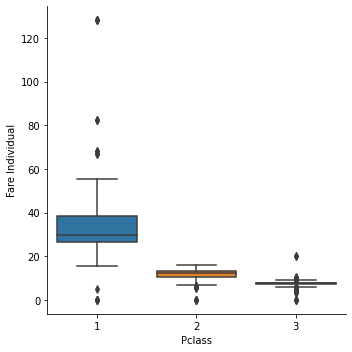

In [24]:
figure = sns.factorplot(x='Pclass' , y="Fare Individual", data=data, kind="box")

In [25]:
data[ data['Fare Individual'] > 100]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived,Ticket Shared With,Fare Individual
PassengerId,,,,,,,,,,,,,
259,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.33,NaN,C,1.0,4,128.0825
680,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.33,B51 B53 B55,C,1.0,4,128.0825
738,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.33,B101,C,1.0,4,128.0825
1235,1,"Cardeza, Mrs. James Warburton Martinez (Charlo...",female,58.0,0,1,PC 17755,512.33,B51 B53 B55,C,NaN,4,128.0825


* These outliers have absurdly high values but share the common fact that they survived.
* Let's verify if the passengers with outlier fares had a significant difference in chance of surviving.

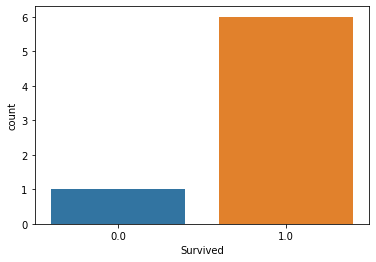

In [26]:
figure = sns.countplot(x="Survived", data=data[ data['Fare Individual'] > 60 ])

* It seems like paying high amounts of money meant getting preference.
* Verifying if the same is applicable for all classes.

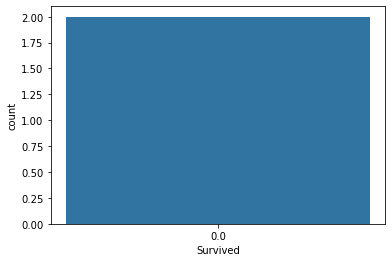

In [27]:
figure = sns.countplot(x="Survived", data=data[ (data['Fare Individual'] > 15)
                                              & (data['Pclass'] == 3)])

* So paying significantly higher than others did not affect survivability for anyone is Pclass 3. No outliers were found in Pclass 2.
* Since paying more did not have any effect, either the prices were unfair (each passenger persuaded to pay the most they can) or the data contains some noise.
* Checking if the survivability had any effect of Pclass.

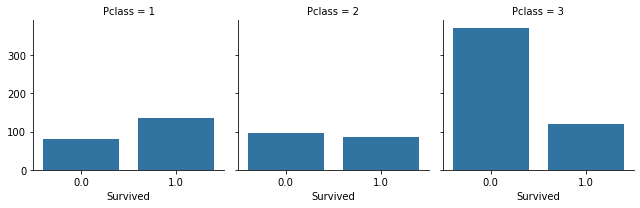

In [28]:
facet = sns.FacetGrid(data, col='Pclass')
figure = facet.map(sns.countplot, 'Survived')

* Evidently, Pclass had a significant effect on survivability of a passenger.
* It should also be noted that in Pclass 1, the distribution in survivability is significantly different from that observed in the previous outlier survivability plot.
* Checking the survivability distribution in Pclass 1 wrt Fare paid.

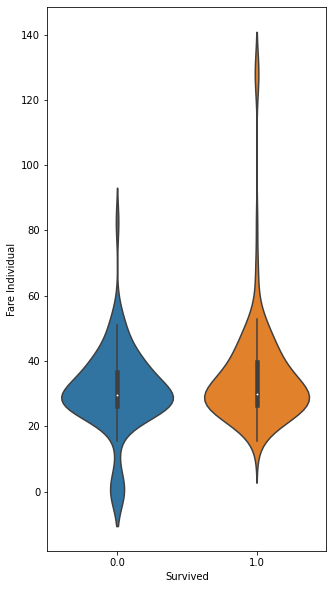

In [29]:
figure = plt.figure(figsize=(5, 10))
figure = sns.violinplot(x='Survived', y='Fare Individual', data=data[ data['Pclass'] == 1])

* It is observed that fair paid is very significant in Pclass 1 while it's not as significant in others for survivability.
* Let us also have a look at the distribution in Sex when it comes to survivability.

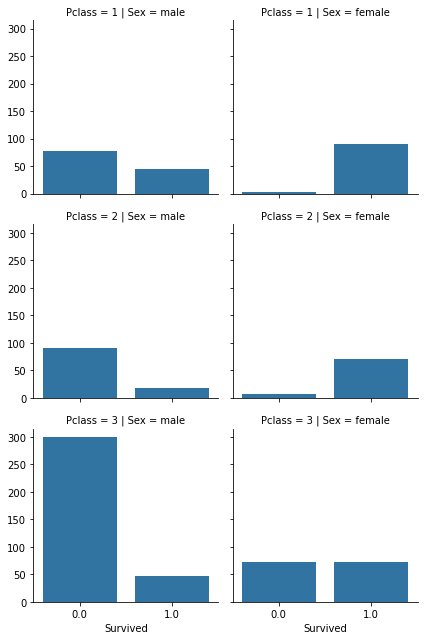

In [30]:
facet = sns.FacetGrid(data, row='Pclass', col='Sex')
figure = facet.map(sns.countplot, 'Survived')

* A significantly higher number of females survived in each class except for in Pclass 3.
* Another significant trend is that males had a higher probablity of dying across all Pclass.
* It is inferred that more preference was given to women.
* Let's see how survivability varies with age.

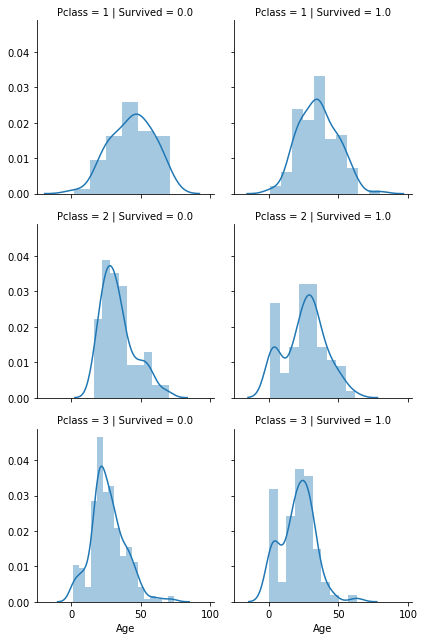

In [31]:
facet = sns.FacetGrid(data, col='Survived', row='Pclass')
figure = facet.map(sns.distplot, 'Age')

* It seems that more preference was given to children across all classes.
* Even though preference was given, some of them did not survive.
* This could be due to extreme cold or any other unrepresented factor(s).

### 1.1 Imputing missing values

In [32]:
check_null(data)

Total Columns: 1309


,Number_Missing,% Missing,Missing?
Cabin,1014,77.463713,True
Survived,418,31.932773,True
Age,263,20.091673,True
Embarked,2,0.152788,True
Fare,1,0.076394,True
Fare Individual,1,0.076394,True


#### 1.1.1 Fare

In [33]:
data[data['Fare'].isnull()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived,Ticket Shared With,Fare Individual
PassengerId,,,,,,,,,,,,,
1044,3,"Storey, Mr. Thomas",male,60.0,0,0,3701,NaN,NaN,S,NaN,1,NaN


In [34]:
required = data[  (data['Pclass'] == 3) 
     & (data['Age'] > 40 )
     & (data['Embarked'] == 'S' )
     & (data['SibSp'] == 0 )
     & (data['Parch'] == 0 ) 
     & (data['Fare'].notnull()) 
    ].sort_values(by='Fare')['Fare'].mean()

data.at[1044, 'Fare'] = round(required, ndigits=2)
data.at[1044, 'Fare Individual'] = round(required, ndigits=2)
data[ data.index == 1044]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived,Ticket Shared With,Fare Individual
PassengerId,,,,,,,,,,,,,
1044,3,"Storey, Mr. Thomas",male,60.0,0,0,3701,7.48,NaN,S,NaN,1,7.48


#### 1.1.2 Embarked

In [35]:
data[ data['Embarked'].isnull() ]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived,Ticket Shared With,Fare Individual
PassengerId,,,,,,,,,,,,,
62,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,1.0,2,40.0
830,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,1.0,2,40.0


* In order to impute 'Embark', I will use the Pclass and Fare distributions.

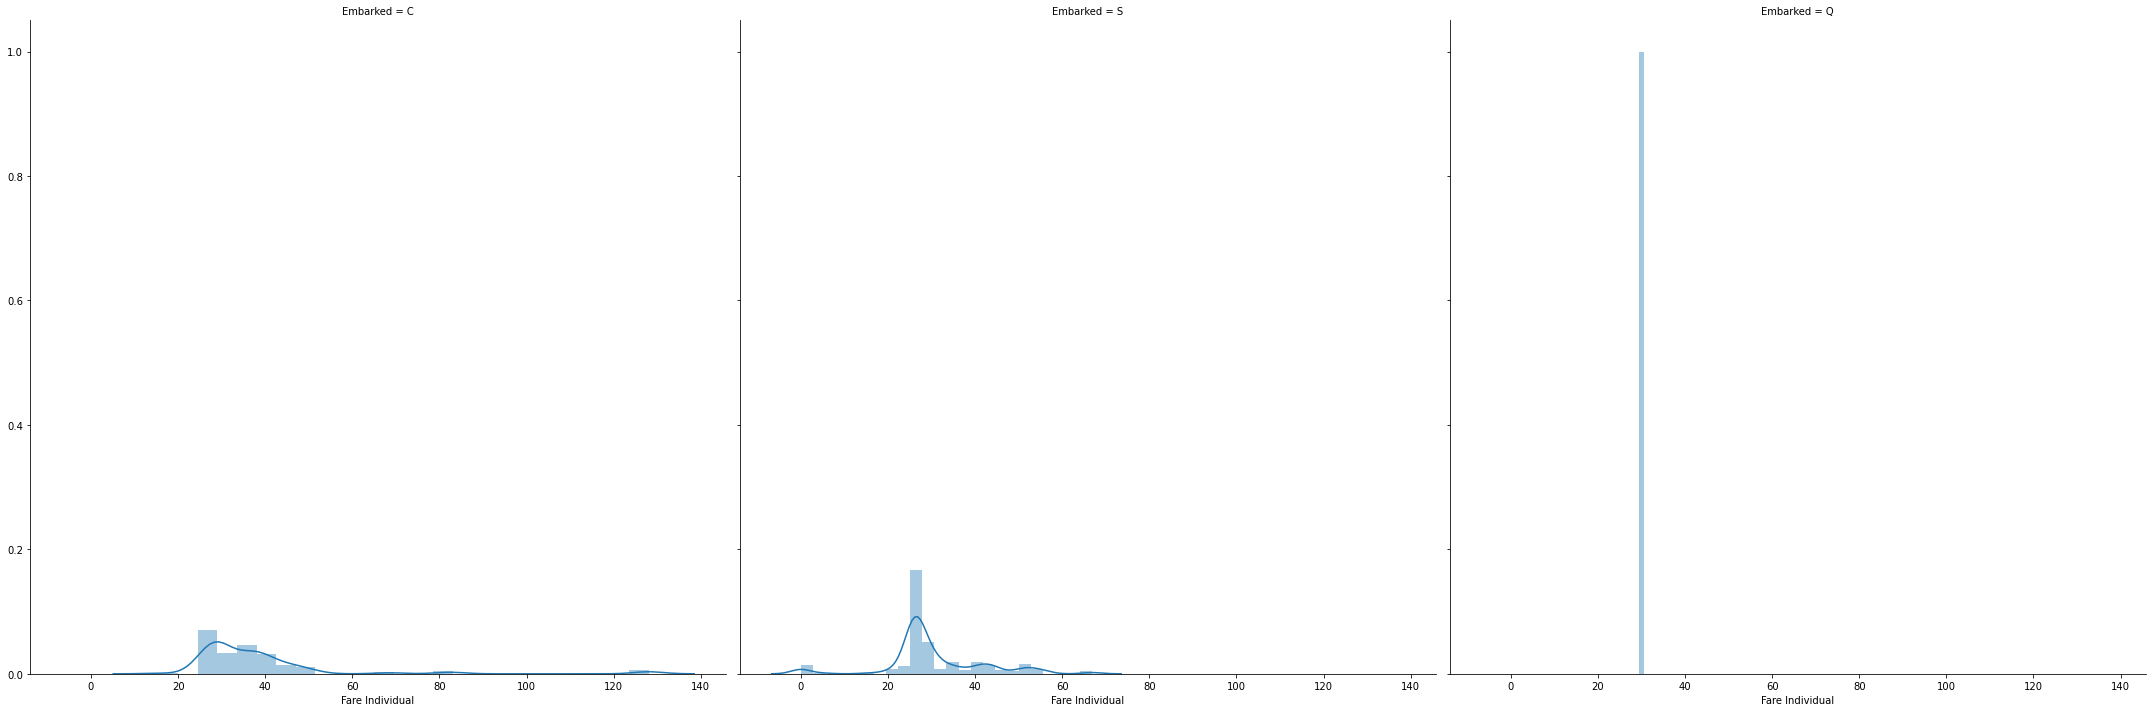

In [36]:
facet = sns.FacetGrid(data[ data['Pclass'] == 1], col='Embarked', height=10)
figure = facet.map(sns.distplot, 'Fare Individual', )

* More people belonging to Pclass 1 have a Fare Individual about 40 in Embarked C.

In [37]:
data['Embarked'].update( data[ data['Embarked'].isnull() ]['Embarked'].fillna('C'))
data[ data['Ticket'] == '113572']

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived,Ticket Shared With,Fare Individual
PassengerId,,,,,,,,,,,,,
62,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,C,1.0,2,40.0
830,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,C,1.0,2,40.0


# Age

* Tried training a model for Age imputation but the errors were too high.
* Using titles of people to group them.
* Imputing using a random variable using the title group's statistics.

In [38]:
data['Title'] = data['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

In [39]:
data['Title'].value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Major             2
Ms                2
Mlle              2
Don               1
Sir               1
Mme               1
Capt              1
Dona              1
Jonkheer          1
the Countess      1
Lady              1
Name: Title, dtype: int64

* Titles will allow us to impute values using a general range.

In [40]:
# for Title for Preference
# * Titles include information about some people holding strong social positions which may affect the preference given to them to board the lifeboats.
# * Grouping the royalty/assumed physically fit titles into groups.
# * Not grouping the female titles into royalty as female passengers had a highly skewed survivability which may affect the usefulness of this grouping.

In [41]:
data['Title for Age'] = data['Title']

In [42]:
data['Title for Age'] = np.where( data['Title'].isin(['Jonkheer', 'Don', 'Dr']), 'Mr', data['Title for Age'])
data['Title for Age'] = np.where( data['Title'].isin(['Mlle', 'Ms', 'Mme']), 'Miss', data['Title for Age'] )
data['Title for Age'] = np.where( data['Title'].isin(['Lady', 'the Countess', 'Dona', 'Lady']), 'Mrs', data['Title for Age'])
data['Title for Age'] = np.where( data['Title'].isin(['Capt', 'Col', 'Rev', 'Major']), 'Sir', data['Title for Age'])

In [43]:
data['Title for Age'].value_counts()

Mr        767
Miss      265
Mrs       200
Master     61
Sir        16
Name: Title for Age, dtype: int64

In [44]:
def n_random(num_array, n, **kwargs):
    '''Returns an array with n random values based on
    passed data. Accepts "min_val" and "max_val" arguments
    to force random values in range'''
    import scipy
    
    min_val = kwargs['min_val'] if 'min_val' in kwargs else min(num_array)
    max_val = kwargs['max_val'] if 'max_val' in kwargs else max(num_array)
    mean = scipy.mean(num_array.values) if type(num_array) == pd.Series else scipy.mean(num_array)
    std_dev = scipy.stats.tstd(num_array.values) if type(num_array) == pd.Series else scipy.stats.tstd(num_array)
        
    dist = stats.truncnorm((min_val - mean)/std_dev,
                           (max_val - mean)/std_dev,
                           loc=mean, scale=std_dev)

    return dist.rvs(n)

In [45]:
previously_missing = data[ data['Age'].isnull()].index

In [46]:
for title in data['Title for Age'].unique():
    missing_data = data[ (data['Title for Age']==title) & (data['Age'].isnull()) ]
    
    # Imputing missing Age values using available age values
    for p_index in missing_data.index:
        
        available_data = data[ (data['Age'].notnull()) & (data['Title for Age'] == title)]
        
        data.at[ p_index, 'Age'] = round( n_random( available_data['Age'], 1)[0] )

In [47]:
data[ data.index.isin(previously_missing) ][['Title for Age', 'Age']].sort_values(by='Title for Age')

,Title for Age,Age
PassengerId,,
1309,Master,5.0
177,Master,9.0
160,Master,4.0
66,Master,5.0
1231,Master,5.0
...,...,...
1141,Mrs,46.0
850,Mrs,44.0
257,Mrs,25.0


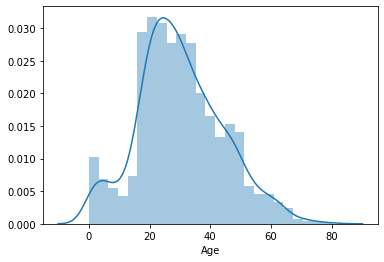

In [48]:
figure = sns.distplot(data['Age'])

# Cabin

In [49]:
data[ data['Cabin'].notnull() ]['Cabin']

PassengerId
2        C85
4       C123
7        E46
11        G6
12      C103
        ... 
1296     D40
1297     D38
1299     C80
1303     C78
1306    C105
Name: Cabin, Length: 295, dtype: object

* Although it would not be possible to impute values in Cabin, some information could be used from it such as the deck and any relation with ticket.
* Checking to verify if the previously made feature Ticket Shared With implies sharing of cabins.

In [50]:
# Total number of cabins available
data[ data['Cabin'].notnull() ]['Cabin'].nunique()

186

In [51]:
grouped_cabins = data[ data['Cabin'].notnull() ].groupby('Cabin').groups

cabin_shared_with = {}

for cabin in grouped_cabins:
    cabin_shared_with[cabin] = len(grouped_cabins[cabin])

data['Cabin Shared With'] = 0
for cabin in cabin_shared_with:
    data['Cabin Shared With'] = np.where( data['Cabin'] == cabin,
                                         cabin_shared_with[cabin], 
                                         data['Cabin Shared With'])

In [52]:
# DF containing unprocessed Cabin, Cabin Shared With, Ticket and Ticket Shared With data
df_check_share = data[ data['Cabin'].notnull() ][['Cabin', 'Cabin Shared With', 'Ticket', 'Ticket Shared With']].sort_values(by='Cabin')

In [53]:
cabin_vc = df_check_share['Cabin'].value_counts()

In [54]:
mask_passengers_split = (df_check_share['Cabin Shared With'] < df_check_share['Ticket Shared With'])
mask_passengers_together = (df_check_share['Cabin Shared With'] == df_check_share['Ticket Shared With'])
mask_passengers_strangers = (df_check_share['Cabin Shared With'] > df_check_share['Ticket Shared With'])

In [55]:
mask_applied = df_check_share[ (df_check_share['Cabin'].isin(cabin_vc[cabin_vc > 1].index))
                              & (mask_passengers_together)
                             ].sort_values(by='Cabin')
mask_applied

,Cabin,Cabin Shared With,Ticket,Ticket Shared With
PassengerId,,,,
1185,A34,3,33638,3
1266,A34,3,33638,3
446,A34,3,33638,3
524,B18,2,111361,2
330,B18,2,111361,2
...,...,...,...,...
810,E8,2,113806,2
619,F4,4,230136,4
1218,F4,4,230136,4


* From the above masks, it is clear that multiple combinations of passenger cabin partners exist.
* Some passengers are separated from their family/friends/colleagues.
* Some passengers are together with  their family/friends/colleagues in a single cabin.
* Some passengers are together with their family/friends/colleagues along with other strangers in a single cabin.
* Some passengers are alone.
* Although this data can be used as a feature, the amount of missing Cabin values makes it impossible to do so effectively.

In [56]:
k = mask_applied['Cabin'].value_counts()
k_df = k.reset_index()
k_df[ (k_df['index'].str[0]).isin(['D', 'E', 'C']) ]

,index,Cabin
0,C23 C25 C27,6
5,C89,2
6,D10 D12,2
7,C93,2
9,D20,2
11,E31,2
12,C31,2
13,E46,2
15,C85,2
16,C92,2


* It may be concluded from the above table that First Class cabins housed only 2 passengers.

In [57]:
k = mask_applied['Cabin'].value_counts()
k_df = k.reset_index()
k_df[ (k_df['index'].str[0]).isin(['F', 'G']) ]

,index,Cabin
1,F4,4


In [58]:
mask_applied[ mask_applied['Cabin'] == 'F4']

,Cabin,Cabin Shared With,Ticket,Ticket Shared With
PassengerId,,,,
619,F4,4,230136,4
1218,F4,4,230136,4
1070,F4,4,230136,4
184,F4,4,230136,4


* From the given data, it may be concluded that Third Class cabins housed 4 passengers.
* Although according to public data, upto 10 passengers could have housed 1 Third Class cabin.

#### Looking for a relation between Tickets and Pclass / Cabin

In [59]:
data['Ticket Prefix'] = data['Ticket'].apply(lambda x: ' '.join(x.split(' ')[:-1]))

In [60]:
k_vc = data['Ticket Prefix'].value_counts().sort_values(ascending=False)
k_vc

               961
PC              92
C.A.            46
SOTON/O.Q.      16
STON/O 2.       14
W./C.           14
CA.             12
A/5             12
SC/PARIS        11
A/5.            10
CA              10
F.C.C.           9
C                8
SOTON/OQ         8
S.O.C.           7
STON/O2.         7
S.O./P.P.        7
A/4              6
SC/Paris         5
PP               4
SC/AH            4
SOTON/O2         3
A.5.             3
F.C.             3
S.C./PARIS       3
A/4.             3
A./5.            3
W.E.P.           2
SC               2
WE/P             2
P/PP             2
STON/OQ.         1
SC/A4            1
A/S              1
S.W./PP          1
A. 2.            1
S.C./A.4.        1
SW/PP            1
Fa               1
SC/A.3           1
S.O.P.           1
C.A./SOTON       1
AQ/3.            1
SCO/W            1
LP               1
SC/AH Basle      1
A4.              1
AQ/4             1
S.P.             1
W/C              1
SO/C             1
Name: Ticket Prefix, dtype: int

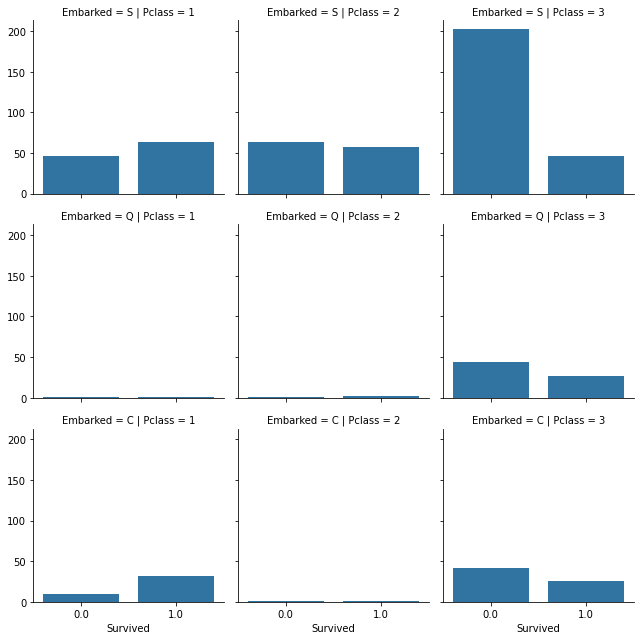

In [61]:
required = data[ data['Ticket Prefix'].isin(['']) ]
facet = sns.FacetGrid(required, col='Pclass', row='Embarked')
figure = facet.map(sns.countplot, 'Survived')

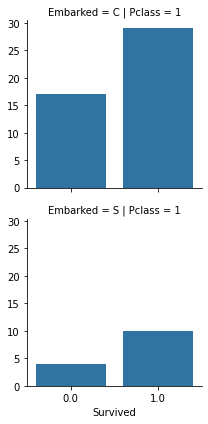

In [62]:
required = data[ data['Ticket Prefix'].isin(['PC']) ]
facet = sns.FacetGrid(required, col='Pclass', row='Embarked')
figure = facet.map(sns.countplot, 'Survived')

* There doesn't seem to be any strong relation between Ticket Prefix and Passenger Class

In [63]:
data['Deck'] = data['Cabin'].str[0]
data['Deck'] = data['Deck'].fillna('Z')

In [64]:
data['Deck'].value_counts().sort_index()

A      22
B      65
C      94
D      46
E      41
F      21
G       5
T       1
Z    1014
Name: Deck, dtype: int64

In [65]:
data[ data['Cabin'].notnull() ]['Pclass'].value_counts()

1    256
2     23
3     16
Name: Pclass, dtype: int64

In [66]:
data[ data['Cabin'].notnull() ]['Deck'].value_counts()

C    94
B    65
D    46
E    41
A    22
F    21
G     5
T     1
Name: Deck, dtype: int64

* The available cabin data can be used to predict the weighted distance till the nearest lifeboats.
* Weighted distance will be used to simulate the unknown cabin locations and whereabouts.
* So a weighted distance for a set of passengers on a deck would roughly give the distance required to reach the lifeboats.
* This distance would in turn determine their likelyhood to get into a lifeboat first, which directly increases their chances of survival.
* As for the other classes, only a few imputations would be possible.
* Data augmentation would need to be carried out in order to calculate the weighted distance for all passngers.

To Do:
Use cabin locations to get better weighted distances.

In [72]:
k = data[ data['Cabin'].notnull() ]['Cabin'].sort_values()

In [73]:
for i in k[ k.str[0].isin(['B'])]:
    print(i)

B10
B101
B102
B11
B18
B18
B19
B20
B20
B22
B22
B24
B26
B28
B28
B3
B30
B35
B35
B36
B37
B38
B39
B4
B41
B41
B42
B45
B45
B49
B49
B5
B5
B50
B51 B53 B55
B51 B53 B55
B51 B53 B55
B52 B54 B56
B57 B59 B63 B66
B57 B59 B63 B66
B57 B59 B63 B66
B57 B59 B63 B66
B57 B59 B63 B66
B58 B60
B58 B60
B58 B60
B61
B69
B69
B71
B71
B73
B77
B77
B78
B78
B79
B80
B82 B84
B86
B94
B96 B98
B96 B98
B96 B98
B96 B98


In [74]:
import cv2

ModuleNotFoundError: No module named 'cv2'